## Quantum Machine Learning in HEP using Qibo

#### TOC
1. A look to Qibo's primitives.
2. Defining a parametric quantum circuit.
3. Using it as model to fit Parton Distribution Functions.

In [125]:
import matplotlib.pyplot as plt
import numpy as np

import qibo
from qibo import Circuit, gates, hamiltonians
from qibo.optimizers import optimize

In [24]:
# set qibo backend depending on your problem
qibo.set_backend(backend="numpy")
# if we want to have a look to all the supported backends
qibo.list_available_backends()

[Qibo 0.2.9|INFO|2024-06-26 15:47:34]: Using numpy backend on /CPU:0
[2024-06-26 15:47:34,606] INFO: Using numpy backend on /CPU:0


{'numpy': True,
 'tensorflow': True,
 'pytorch': True,
 'qibojit': {'numba': True, 'cupy': False, 'cuquantum': False},
 'qibolab': False,
 'qibo-cloud-backends': False,
 'qibotn': {'cutensornet': False, 'qutensornet': False}}

In [222]:
def visualize_state(counter):
    """Plot state's frequencies."""
        
    fig, ax = plt.subplots(figsize=(5, 5 * 6/8))
    
    ax.set_title('State visualization')
    ax.set_xlabel('States')
    ax.set_ylabel('#')
    plt.xticks(rotation=90)
       
    for i, state in enumerate(counter):
            ax.bar(state, counter[state], color='#C194D8', edgecolor="black")
    plt.show()

def plot_uquark(x, labels, predictions=None):
    """Plot target function and eventual predictions."""
    
    fig, ax = plt.subplots(figsize=(5, 5 * 6/8))
    
    ax.set_title(r'$u$-quark PDF')
    ax.set_xlabel('x')
    ax.set_ylabel(r'$u f(x)$')

    plt.plot(x, labels, color="black", ls="--", lw=1.5, label="Labels", marker=".", markersize=10, alpha=0.7)
    if predictions is not None:
        plt.plot(x, predictions, color="#C194D8", ls="-", lw=1.5, label="Predictions", marker=".", markersize=10, alpha=0.7)

    ax.set_xscale("log")
    
    plt.legend()
    plt.show()

### Exercise 1: preparing a Bell state

In [248]:
# To prepare the Bell state we need two qubits
nqubits = 2

c = Circuit(nqubits)
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.M(*range(nqubits)))

MeasurementResult(qubits=(0, 1), nshots=0)

In [249]:
print(c.draw())

q0: ─H─o─M─
q1: ───X─M─


In [250]:
print(c.summary())

Circuit depth = 3
Total number of gates = 3
Number of qubits = 2
Most common gates:
h: 1
cx: 1
measure: 1


The circuit outcome depends on the simulation one decides to run. 

In [251]:
# We can execute the circuit setting the number of shots
outcome = c(nshots=1000)

print(f"The outcome of a simulation is a quantum state: {outcome}\n")
print(f"We can access the state probabilities: {outcome.probabilities()}\n")
print(f"and also the simulated frequencies: {outcome.frequencies()}.")

The outcome of a simulation is a quantum state: (0.70711+0j)|00> + (0.70711+0j)|11>

We can access the state probabilities: [0.5 0.  0.  0.5]

and also the simulated frequencies: Counter({'11': 501, '00': 499}).


If we repeat the execution, the probabilities remain the same (they are an exact result) while the frequencies change.

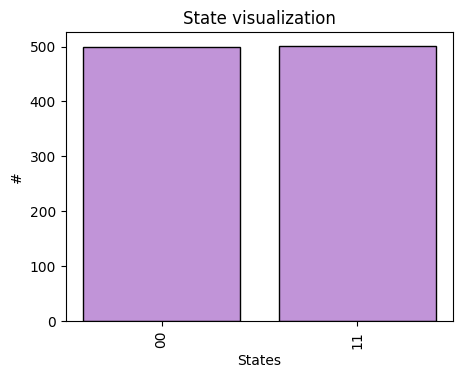

In [252]:
visualize_state(outcome.frequencies())

### Exercise 1.1: compute expectation values after executing circuit

In [253]:
h = hamiltonians.TFIM(nqubits=2, h=0.5)

print(f"Hamiltonian matrix:\n{h.matrix}")
print(f"\nEigenvalues:\n{h.eigenvalues()}")
print(f"\nEigenvectors:\n{h.eigenvectors()}")

Hamiltonian matrix:
[[-2. -0.j -0.5-0.j -0.5-0.j -0. -0.j]
 [-0.5-0.j  2. -0.j -0. -0.j -0.5-0.j]
 [-0.5-0.j -0. -0.j  2. -0.j -0.5-0.j]
 [-0. -0.j -0.5-0.j -0.5-0.j -2. -0.j]]

Eigenvalues:
[-2.23606798 -2.          2.          2.23606798]

Eigenvectors:
[[ 6.88190960e-01+0.j  7.07106781e-01+0.j -3.33066907e-16-0.j
  -1.62459848e-01+0.j]
 [ 1.62459848e-01+0.j  3.83491058e-17+0.j  7.07106781e-01+0.j
   6.88190960e-01+0.j]
 [ 1.62459848e-01+0.j  3.83491058e-17+0.j -7.07106781e-01+0.j
   6.88190960e-01+0.j]
 [ 6.88190960e-01+0.j -7.07106781e-01+0.j -4.44089210e-16+0.j
  -1.62459848e-01+0.j]]


In [254]:
outcome = c()
expval = h.expectation(outcome.state())

print(expval)

-1.9999999999999996


### Parametric quantum circuits

In [256]:
def build_parametric_circuit(nlayers):
    """Construct the scheleton of the parametric quantum circuit."""
    c = Circuit(1)
    for _ in range(nlayers):
        c.add(gates.RY(q=0, theta=0.))
        c.add(gates.RZ(q=0, theta=0.))
    c.add(gates.M(0))
    return c

In [257]:
pqc = build_parametric_circuit(nlayers=3)
print(c.draw(), "\n")
print(c.summary())

q0: ─H─o─M─
q1: ───X─M─ 

Circuit depth = 3
Total number of gates = 3
Number of qubits = 2
Most common gates:
h: 1
cx: 1
measure: 1


In [186]:
print(pqc.get_parameters())

[(0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,)]


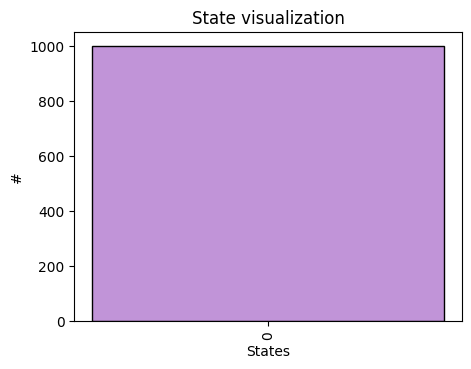

In [258]:
visualize_state(pqc(nshots=1000).frequencies())

In [259]:
np.random.seed(42)
nparams = len(pqc.get_parameters())
new_parameters = np.random.randn(nparams)

pqc.set_parameters(new_parameters)
print(pqc.get_parameters())

[(0.4967141530112327,), (-0.13826430117118466,), (0.6476885381006925,), (1.5230298564080254,), (-0.23415337472333597,), (-0.23413695694918055,)]


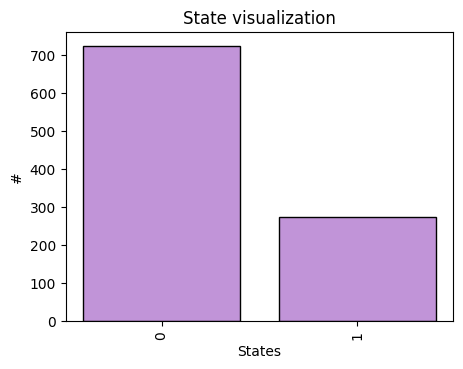

In [260]:
visualize_state(pqc(nshots=1000).frequencies())

### Exercise 2: training a parametric circuit to fit a PDF

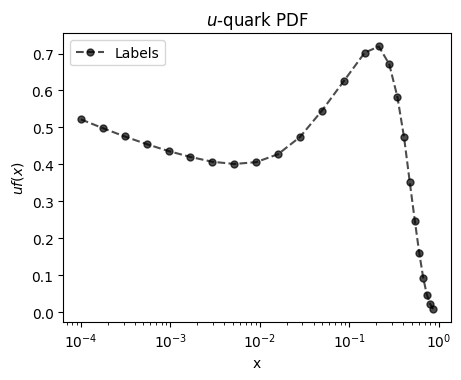

In [261]:
data = np.loadtxt("data/u.dat")

x_data = data.T[0]
labels = data.T[1]

indexes = np.arange(0, len(labels), 4)
x_data = x_data[indexes]
labels = labels[indexes]

plot_uquark(x_data, labels)

In [262]:
def set_parameters(circuit, nlayers, parameters, x):
    """
    Upload data and trainable parameters into a circuit.
    We want to combine data and params so that angle = p1 * x + p2
    """
    params = []
    index = 0
    for _ in range(nlayers):
        params.append(parameters[index] * x + parameters[index + 1])
        params.append(parameters[index + 2] * np.log(x) + parameters[index + 3])
        index += 4
    circuit.set_parameters(params)
    return circuit


def predict(parameters, data, nlayers, circuit, hamiltonian):
    """Compute predictions given dataset and parameters."""
    predictions = []
    for x in data:
        circuit = set_parameters(circuit, nlayers, parameters, x)
        predictions.append(hamiltonian.expectation(circuit().state()))
    return predictions


def loss_function(parameters, data, labels, circuit, nlayers, hamiltonian):
    """Compute loss function considering all data and a given set of parameters."""
    loss = 0
    predictions = predict(parameters, data, nlayers, circuit, hamiltonian)
    for i, pred in enumerate(predictions):
        loss += (pred - labels[i])**2
    return loss

In [263]:
nlayers = 5
pqc = build_parametric_circuit(nlayers)

np.random.seed(42)
initial_parameters = np.random.randn(nlayers * 4)
pqc = set_parameters(pqc, nlayers, initial_parameters, 0.3)

h = hamiltonians.Z(1)

In [264]:
print(pqc.draw())

q0: ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─M─


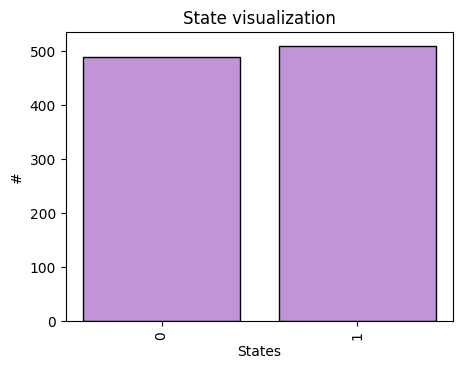

In [265]:
visualize_state(pqc(nshots=1000).frequencies())

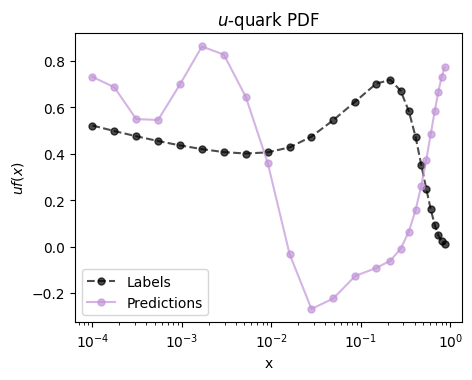

In [266]:
predictions = predict(initial_parameters, x_data, nlayers, pqc, h)
plot_uquark(x_data, labels, predictions)

In [247]:
optimization_result = optimize(loss_function, initial_parameters=initial_parameters, method="cma", args=(x_data, labels, pqc, nlayers, h), options={"maxiter": 1500})

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=487857, Wed Jun 26 17:06:10 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 6.934148414034656e+00 1.0e+00 1.58e+00  2e+00  2e+00 0:00.1
    2     24 4.788011013401249e+00 1.1e+00 1.52e+00  1e+00  2e+00 0:00.2
    3     36 5.703710961952185e+00 1.1e+00 1.47e+00  1e+00  1e+00 0:00.3
   41    492 4.712674812544873e+00 1.8e+00 6.47e-01  6e-01  7e-01 0:03.4
   90   1080 1.159847205199835e+00 2.1e+00 2.59e-01  2e-01  3e-01 0:07.4
  100   1200 1.231123692802531e+00 2.4e+00 2.05e-01  2e-01  2e-01 0:08.2
  173   2076 9.109898662941138e-02 4.0e+00 4.18e-02  3e-02  5e-02 0:14.3
  200   2400 6.826674227669334e-02 4.9e+00 2.23e-02  1e-02  3e-02 0:16.5
  298   3576 2.232065513757477e-02 1.5e+01 1.76e-02  6e-03  3e-02 0:24.5
  300   3600 2.289284214550277e-02 1.5e+01 1.73e-02  5e-03  3e-02 0:24.7
  400   4800 6.120979277231547e-03 4.3e+01 1.90e-02  5e-03  7e-02 0:33.0
  500   6000 1.382176099686473e-0

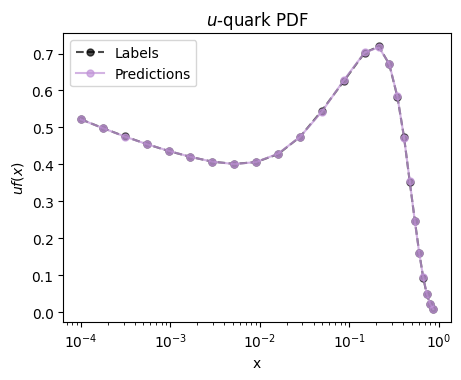

In [267]:
best_params = optimization_result[1]
predictions = predict(best_params, x_data, nlayers, pqc, h)
plot_uquark(x_data, labels, predictions)